In [1]:
#!/usr/bin/python
#coding = utf-8
#Author: Selvaria

# 线性回归的从零手动实现

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
import random

plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False  # 步骤二（解决坐标轴负数的负号显示问题）

D:\Selvaria\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [2]:
# 3.2.1 生成数据集

num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = tf.random.normal(shape=(num_examples, num_inputs), stddev = 1) #stddev: 正态分布的标准差。
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b # 标准y
labels += tf.random.normal(labels.shape,stddev=0.01) # 在标准y值后添加噪声

print(features[0], labels[0])

tf.Tensor([-1.163748  -1.2310454], shape=(2,), dtype=float32) tf.Tensor(6.053135, shape=(), dtype=float32)


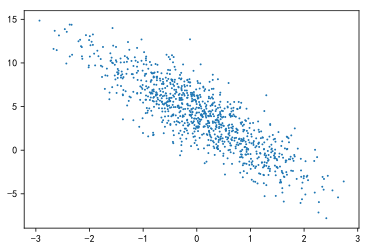

In [5]:
#画图

# def set_figsize(figsize=(3.5, 2.5)):
#     plt.rcParams['figure.figsize'] = figsize

# set_figsize()
plt.scatter(features[:, 1], labels,s=1)

In [9]:
# 3.2.2读取数据

import numpy as np

def data_iter(batch_size, features, labels): # 定义函数（生成器），每次返回batch_size大小的随机样本
    features = np.array(features)
    labels = np.array(labels)
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) #打乱indice列表，即下面要选取的features和labels组的索引顺序
#     print(indices[:5])
    for i in range(0, num_examples, batch_size):
#         j = np.array(indices[i:min(i + batch_size, num_examples)])
        j = indices[i:min(i + batch_size, num_examples)]
#         print(j, type(j))
        yield features[j], labels[j]
        
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

[[ 0.23259123  0.4402026 ]
 [ 0.5640461   0.8027766 ]
 [ 0.67288864 -1.3311054 ]
 [ 1.0018789  -1.8346363 ]
 [ 0.3735784   0.6038118 ]
 [-0.11780452  1.6040628 ]
 [ 0.31495765  0.33607414]
 [-1.35302     1.0125312 ]
 [ 0.8717051   0.09228129]
 [-0.8981931   0.99620837]] [ 3.1895065  2.5959806 10.069133  12.465583   2.907014  -1.492441
  3.6937332 -1.9522083  5.636886  -0.9713348]


In [26]:
# 3.2.3 初始化模型参数
# 我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

w = tf.Variable(tf.random.normal((num_inputs, 1), stddev=0.01))
b = tf.Variable(tf.zeros((1,)))

print('w:',w,'b:',b)

w: <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.0053104 ],
       [-0.01264064]], dtype=float32)> b: <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


In [16]:
# 3.2.4定义模型

def linreg(X, w, b):
    return tf.matmul(X, w) + b

# 3.2.5 定义损失函数
# 我们使用上一节描述的平方损失来定义线性回归的损失函数。
# 在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同。

def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 /2

In [7]:
# 3.2.6 定义优化算法
# 实现小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。

def sgd(params, lr, batch_size, grads): 
    """
    params: 张量；
    lr：学习率；
    batch_size：批量大小；
    grads：梯度值
    """
    for i, param in enumerate(params):
        # 这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值
        # 注意这里是传入的params是列表（矩阵），修改的时候是在原param地址上进行修改，所以param被改变了，参考下个cell
        param.assign_sub(lr * grads[i] / batch_size) # 这里相当于 param = param - (lr * grads[i] / batch_size)
            

In [1]:
def test_para(para):
    para = para - 1
    print(para)
    
para = 5
test_para(para)    
print(para)

def lists(l1, l2):
    l1.append(1) #
    l2 = [1, 2, 3]

list1 = [9, 8, 7]
list2 = [9, 8, 7]
print(list1, list2)
lists(list1, list2)
print(list1, list2) #可以看到，重新赋值后不会对原参数造成改变，但是append则会

4
5
[9, 8, 7] [9, 8, 7]
[9, 8, 7, 1] [9, 8, 7]


In [24]:
# 3.2.7训练模型

lr = 0.03
num_epochs = 3
net = linreg # 线性函数公式
loss = squared_loss # 损失函数

for epoch in range(num_epochs): #训练3次
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as t:
            t.watch([w,b])
            l = loss(net(X, w, b), y) 
            # 计算损失函数的梯度
        grads = t.gradient(l, [w, b])
        sgd([w, b], lr, batch_size, grads)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, tf.reduce_mean(train_l))) 
    #.reduce_mean 函数用于计算张量tensor沿着指定的数轴（tensor的某一维度）上的的平均值，不指定轴则为所有值

epoch 1, loss 0.044121
epoch 2, loss 0.000178
epoch 3, loss 0.000050


In [25]:
print(true_w, w)
print(true_b, b)

[2, -3.4] <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9995298],
       [-3.3992393]], dtype=float32)>
4.2 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.199835], dtype=float32)>


In [6]:
# 使用keras配合Tensorflow的简单实现

import tensorflow as tf

num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = tf.random.normal(shape=(num_examples, num_inputs), stddev=1)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += tf.random.normal(labels.shape, stddev=0.01)

In [29]:
# 3.3.2 读取数据
# 虽然tensorflow2.0对于线性回归可以直接拟合，不用再划分数据集，但我们仍学习一下读取数据的方法

from tensorflow import data as tfdata

# shuffle 的 buffer_size 参数应大于等于样本数，batch 可以指定 batch_size 的分割大小。

batch_size = 10
# 将训练数据的特征和标签组合
dataset = tfdata.Dataset.from_tensor_slices((features, labels))
# 随机读取小批量
dataset = dataset.shuffle(buffer_size=num_examples) 
dataset = dataset.batch(batch_size)
data_iter = iter(dataset)

for X, y in data_iter:
    print(X, y)
    break

tf.Tensor(
[[-0.28004652  1.4375948 ]
 [ 0.62491226  1.2365896 ]
 [ 0.48428205  1.3744369 ]
 [-0.718244   -0.10003414]
 [ 1.1533368   0.11077883]
 [ 2.0944276  -0.20019913]
 [-0.7978087  -0.27090424]
 [-0.06802198 -0.41906253]
 [ 0.82946527 -0.44173035]
 [-1.9135466   0.78571606]], shape=(10, 2), dtype=float32) tf.Tensor(
[-1.2481334  1.2534468  0.5024529  3.10007    6.138939   9.064217
  3.532855   5.504871   7.341781  -2.2926474], shape=(10,), dtype=float32)


In [30]:
# tf推荐写法：

for (batch, (X, y)) in enumerate(dataset):
    print(X, y)
    break

tf.Tensor(
[[ 0.02574844 -1.3662008 ]
 [-1.0338122   0.81503147]
 [ 0.376177    0.11432102]
 [ 0.24665084  0.05064851]
 [ 0.24021284  0.66726923]
 [ 0.1067085   1.1761281 ]
 [ 0.27767262  0.27304104]
 [ 0.5487533   1.0560225 ]
 [-1.7259306   0.35064974]
 [-2.1290145  -2.637315  ]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 8.911351   -0.6341619   4.550921    4.5145917   2.4035358   0.41899562
  3.8297615   1.7103382  -0.4536076   8.919041  ], shape=(10,), dtype=float32)


In [7]:
# 3.3.3 定义模型和初始化参数

from tensorflow import keras # 注意，tf2.0后keras最好这样导入，否则会报错，keras还没有完美支持tf2.0
from tensorflow.keras import layers
from tensorflow import initializers as init

model = keras.models.Sequential()
# 指定权重参数每个元素将在初始化时随机采样于均值为0、标准差为0.01的正态分布。偏差参数默认会初始化为零。
model.add(layers.Dense(1, kernel_initializer=init.RandomNormal(stddev=0.01)))

In [11]:
# 更简洁的实现，使用自定义的梯度更新函数再往下看

from tensorflow.keras import optimizers

model.compile(loss='mean_squared_error',
              optimizer=optimizers.SGD(learning_rate=0.03),
              metrics=['mae'])

history = model.fit(features, labels,
                    batch_size=1,
                    epochs=3)
# test_scores = model.evaluate(x_test, y_test, verbose=2)

Train on 1000 samples
Epoch 1/3
1000/1000 [==============================] - 1s 887us/sample - loss: 1.0719e-04 - mae: 0.0083
Epoch 2/3
1000/1000 [==============================] - 1s 720us/sample - loss: 1.0344e-04 - mae: 0.0081
Epoch 3/3
1000/1000 [==============================] - 1s 707us/sample - loss: 1.0569e-04 - mae: 0.0081


In [12]:
print(true_w, model.get_weights()[0])
print(true_b, model.get_weights()[1])

[2, -3.4] [[ 1.9968815]
 [-3.399411 ]]
4.2 [4.200065]


In [39]:
# 3.3.4 定义损失函数

from tensorflow import losses
from tensorflow.keras import optimizers

loss = losses.MeanSquaredError()

# 3.3.5 定义优化算法
# 指定学习率为0.03的小批量随机梯度下降（SGD）为优化算法。
trainer = optimizers.SGD(learning_rate=0.03)

# 3.3.6 训练模型

num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for (batch, (X, y)) in enumerate(dataset):
        with tf.GradientTape() as t:
            l = loss(model(X, training=True), y)

        grads = t.gradient(l, model.trainable_variables) #通过 model.trainable_variables 找到需要更新的变量
        trainer.apply_gradients(zip(grads, model.trainable_variables)) #用 trainer.apply_gradients 更新权重

    l = loss(model(features), labels)
    print('epoch %d, loss: %f' % (epoch, l.numpy().mean()))

epoch 1, loss: 0.000295
epoch 2, loss: 0.000098
epoch 3, loss: 0.000099


In [40]:
# 通过model的get_weights()来获得其权重（weight）和偏差（bias）

print(true_w, model.get_weights()[0])
print(true_b, model.get_weights()[1])

[2, -3.4] [[ 1.9999243]
 [-3.3995693]]
4.2 [4.2006407]
